# Single layer graphene with a Mathieu potential superlattice $U(x) = U_0 \cos(2\pi x/a)$

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
a = 100 #[nm] lattice period
hv = 1.97 / 3 #hbar v_D [eV*nm]
n_x = 20
G_max = 3 #max reciprocal lattice vector considered
U0 = .050 #[eV]
delta = 0.0
long_plots = True
density = 0. #electron density in [nm^-2]
temperature = 0.026 #k_B T in eV
eta = 0.002 #energy smoothing [eV]

In [3]:
#lenght of reciprocal lattice vector
G = 2 * np.pi / a
k_cutoff = 0.5 * (2 * G_max + 1) * G
n_sites = (n_x, (2 * G_max + 1) * n_x)
reciprocal_lattice_basis = np.array([[G, 0.],
                                     [0.,2 * k_cutoff]], dtype = float)

#select point group (D2 for rectangular lattice with 2 reflection symmetries)
#angle of the principal axis
theta0 = np.arctan2(reciprocal_lattice_basis[1,0],reciprocal_lattice_basis[0,0])
point_group = Point_Group.dihedral_group(n =2, theta0 = theta0)
#point_group = point_groups.Point_Group(space_dimension=2)

#defines lattice geometry given Bravais lattice 
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group = point_group)    
reciprocal_lattice_vectors = sample.Sample.line_sample(basis_vectors = reciprocal_lattice_basis, cut_off = G_max * G)
potential_components = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
potential_components[reciprocal_lattice_vectors[(1,0)]] = U0/2
potential_components[reciprocal_lattice_vectors[(-1,0)]] = U0/2

k_sample = sample.Unit_Cell_Sample.irreducible_sample(name = '2D_Rectangular_D2',basis_vectors= reciprocal_lattice_basis, denominator=n_sites)
#k_sample = sample.Unit_Cell_Sample.centered_unit_cell(basis_vectors= reciprocal_lattice_basis, denominator=n_sites)

..\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


energy cut-off =  0.14440854231001082


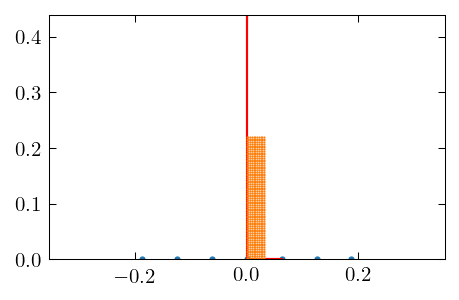

In [4]:
reciprocal_lattice_vectors.plot()
k_sample.plot(ms = 1)
print('energy cut-off = ', hv * k_cutoff)

In [5]:
#################### Hamiltonian and overlap matrices ##########################
class kinetic_function():
    def __init__(self, hv, der = (0,0)):
        self.hv = hv
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return hv * k
        elif self.der == (1,0):
            return hv * np.array([1.,0.])
        elif self.der == (0,1):
            return hv * np.array([0.,1.])
        else:
            return np.array([0,0])

H0 = Momentum_Conserving_Operator(matrices =  [[pauli_matrix('x'), pauli_matrix('y')], pauli_matrix('z')],
                                  coefficients = [kinetic_function(hv = hv), delta],
                                  collapse = True)
                                                  
H = build_kinetic_hamiltonian(H0, 
                              reciprocal_lattice_vectors = reciprocal_lattice_vectors)                                                   #use a class with a __call__ method instead of lambda function

U = build_potential_hamiltonian(U = pauli_matrix('I'), 
                                potential_components =potential_components, 
                                reciprocal_lattice_vectors = reciprocal_lattice_vectors)

p_x = build_kinetic_term([pauli_matrix('x'), pauli_matrix('y')], 
                           kinetic_function(hv=hv,der=(1,0)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)
p_y = build_kinetic_term([pauli_matrix('x'), pauli_matrix('y')], 
                           kinetic_function( hv=hv,der=(0,1)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)

In [6]:
####################### Output folder ##################################
output_folder = 'test_output/slg_superlattice'
file_name = '/slg_superlattice.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H + U,
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = len(reciprocal_lattice_vectors),
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands()
band_structure.compute_momentum_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
superlattice = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

100%|██████████████████████████████████████████████████████████████████████████████| 781/781 [00:00<00:00, 3440.61it/s]


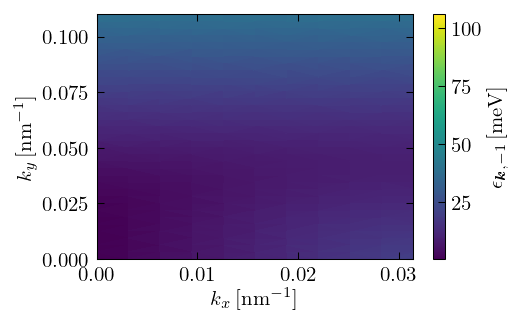

In [7]:
nu =7
#####################################################################
plt.figure()
plt.axes()
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')
plt.xlim(0,G/2)
plt.ylim(0,k_cutoff/2)
plt.tripcolor(superlattice.band_structure.k_sample.coords[:,0],  
              superlattice.band_structure.k_sample.coords[:,1],
              1e3* superlattice.band_structure.energies[nu,:])
cb = plt.colorbar()
cb.set_label(r'$\epsilon_{\bm k,-1}\,[{\rm meV}]$')

# Bands for $k_y = 0$

(0, 0.031415926535897934)

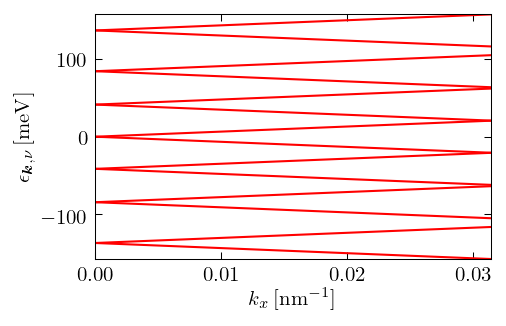

In [8]:
index = superlattice.band_structure.k_sample.integer_coords[:,1] == 0
for nu in range(superlattice.band_structure.energies.shape[0]):
    plt.plot(superlattice.band_structure.k_sample.coords[index,0],
             1e3 * superlattice.band_structure.energies[nu,index],'-',c='r')
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$\epsilon_{\bm k,\nu}\,[{\rm meV}]$')
plt.xlim(0,G/2)
#plt.ylim(-3.5 *hv * G*1e3 ,3.5 *hv * G*1e3)

# Bands for $k_x = 0$

(0, 0.10995574287564278)

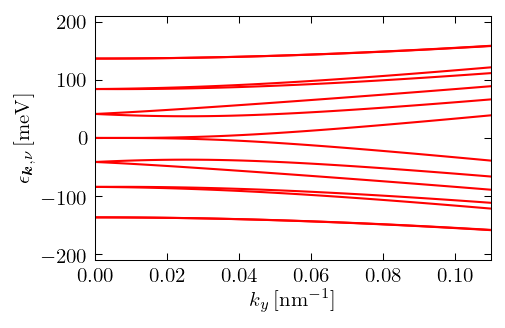

In [9]:
index = superlattice.band_structure.k_sample.integer_coords[:,0] == 0
for nu in range(superlattice.band_structure.energies.shape[0]):
    plt.plot(superlattice.band_structure.k_sample.coords[index,1],
             1e3 * superlattice.band_structure.energies[nu,index],'-',c='r')
plt.xlabel(r'$k_y\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$\epsilon_{\bm k,\nu}\,[{\rm meV}]$')
#plt.ylim(-100,100)
plt.xlim(0,k_cutoff/2)

## Density of states

In [10]:
e_vals = np.linspace(np.amin(superlattice.band_structure.energies), np.amax(superlattice.band_structure.energies),num=250)
e_lims = e_vals[0], e_vals[-1] #energy limits for the figure
dosvals = superlattice.dos(e_vals) 

Text(0.5, 0, '$\\epsilon~[{\\rm ev}]$')

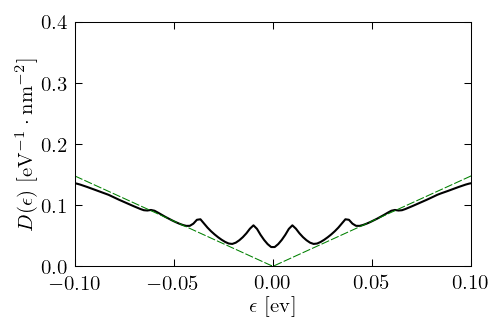

In [11]:
plt.plot(e_vals, dosvals, c='k')
plt.plot(e_vals,2 * abs(e_vals)/(np.pi * hv**2),'--', c='g', lw=0.5)
plt.ylim(0,0.4)
plt.xlim(-0.1,.1)
plt.ylabel(r'$D(\epsilon)~[{\rm eV^{-1}\cdot nm^{-2}}]$')
plt.xlabel(r'$\epsilon~[{\rm ev}]$')

In [12]:
omega_vals = np.linspace(0,0.2, num = 100)
sigma_vals = superlattice.local_conductivity(omega_vals)

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


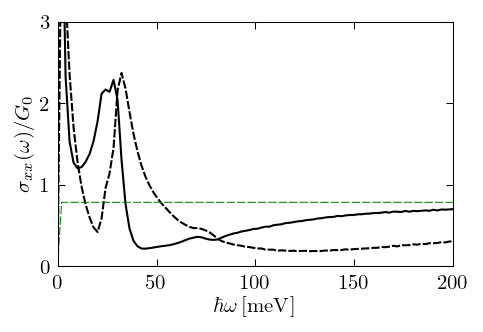

In [13]:
plt.xlabel(r'$\hbar \omega \, [{\rm meV}]$')
plt.ylabel(r'$\sigma_{xx}(\omega)/G_0$')

plt.plot(1e3*omega_vals,np.real(sigma_vals[:,0,0]),c='k')
plt.plot(1e3*omega_vals,np.imag(sigma_vals[:,0,0]),'--',c='k')
plt.plot(1e3*omega_vals,np.heaviside(omega_vals-2*abs(superlattice.band_structure.chemical_potential),0.5)*np.pi/4,'--', c='g', lw=0.5)
plt.plot(1e3*omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.ylim(0,3)
plt.savefig(output_folder +'/conductivity.pdf')

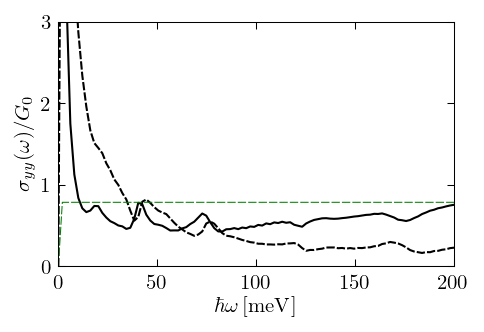

In [14]:
plt.xlabel(r'$\hbar \omega \, [{\rm meV}]$')
plt.ylabel(r'$\sigma_{yy}(\omega)/G_0$')

plt.plot(1e3*omega_vals,np.real(sigma_vals[:,1,1]),c='k')
plt.plot(1e3*omega_vals,np.imag(sigma_vals[:,1,1]),'--',c='k')
plt.plot(1e3*omega_vals,np.heaviside(omega_vals-2*abs(superlattice.band_structure.chemical_potential),0.5)*np.pi/4,'--', c='g', lw=0.5)
plt.plot(1e3*omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.ylim(0,3)
plt.savefig(output_folder +'/conductivity_yy.pdf')